In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from physics import JT_GMS, SMT
from constants import *
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from exp_setup import Cylindrical_Grid, Experiment
from TTM_solver import TwoTemperatureModel

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
Xe_data = read_csv("./data/experimental_data/Xe_5bar_Te.txt", delim_whitespace=True, header=1)
t_data, T_data = Xe_data['t[ns]'], Xe_data['T[kK]']

In [175]:
fit_vals, 5*np.array((σ_Te0, σ_Ti0, σ_d, σ_τei))

(array([16.64487111,  9.3225703 ,  0.12757051,  2.43550564]),
 array([0.28436751, 0.67443883, 0.02848254, 0.68864911]))

In [177]:
from scipy.optimize import curve_fit
from scipy.stats import multivariate_normal


def T_fit_form(t, Te_0, Ti_0, d, τei):
    ΔT0 = (Te_0-Ti_0)
    ΣT0 = (Te_0+Ti_0)
    return ΣT0/2 - d*t + ΔT0/2*np.exp(-2*t/τei)

fit_vals, fit_cov = curve_fit(T_fit_form, Xe_data['t[ns]'], Xe_data['T[kK]'] )
Te0_fit, Ti0_fit, d_fit, τei_fit = fit_vals
σ_Te0, σ_Ti0, σ_d, σ_τei = np.sqrt(np.diag(fit_cov))
# Define ranges for your parameters
N=10

first_half = np.linspace(-1, 0, int(N/2), endpoint=False)  # 50 points from 0 to 1, not including 1
second_half = np.linspace(0, 1, N-int(N/2))  # 50 points from 1 to 2, including 2
# Concatenate the two arrays to get an array from 0 to 2 with 1 in the middle
basic_array  = np.concatenate((first_half, second_half))

Te_0_range = Te0_fit + 3*σ_Te0*basic_array
Ti_0_range = Ti0_fit + 3*σ_Ti0*basic_array
d_range    = d_fit   + 3*σ_d*basic_array
τei_range  = τei_fit + 3*σ_τei*basic_array

# Initialize a 4D array to store the least squares values
lsq_values = np.empty((N,N,N,N))
parameter_normal   = multivariate_normal(fit_vals, fit_cov)
probability_values = parameter_normal.pdf(np.stack(np.meshgrid(Te_0_range, Ti_0_range, d_range, τei_range),axis=-1))
probability_values *= 1/np.max(probability_values)


index=0
# Iterate over all combinations of parameters
for i, Te_0 in enumerate(Te_0_range):
    for j, Ti_0 in enumerate(Ti_0_range):
        for k, d in enumerate(d_range):
            print("{}".format(index/N**4),end='\r')
            for l, τei in enumerate(τei_range):
                
                index = l + k*N + j*N**2 + i*N**3
                # Compute the predicted values
                T_pred = T_fit_form(t_data, Te_0, Ti_0, d, τei)
                
                # Compute the sum of squared residuals
                residuals = T_data - T_pred
                lsq = np.sum(residuals**2)
                
                # Store the least squares value
                lsq_values[i, j, k, l] = lsq

In [247]:

# Define the parameter ranges and labels as global variables
param_ranges = {
    'Te_0': Te_0_range,
    'Ti_0': Ti_0_range,
    'd': d_range,
    'τei': τei_range,
}

best_fit_values = {
    'Te_0': Te0_fit,
    'Ti_0': Ti0_fit,
    'd': d_fit,
    'τei': τei_fit,
}

# Function to plot a 2D slice
def plot_2D_slice(ax, axis1, axis2):
    # Get the ranges for the two axes
    param1_range = param_ranges[axis1]
    param2_range = param_ranges[axis2]

    # Get the indices of the two axes in the 4D array
    axes = ['Te_0', 'Ti_0', 'd', 'τei']
    i = axes.index(axis1)
    j = axes.index(axis2)

    # Get the indices of the other two axes
    other_axes = list(set(range(4)) - {i, j})

    # Find the indices of the closest values to the best fit values for the other two dimensions
    other_indices = [np.abs(param_ranges[axes[k]] - best_fit_values[axes[k]]).argmin() for k in other_axes]

    # Get a 2D slice of the 4D grid
    slice_indices = [slice(None)] * 4
    slice_indices[other_axes[0]] = other_indices[0]
    slice_indices[other_axes[1]] = other_indices[1]
    lsq_slice = lsq_values[slice_indices]
    pdf_slice = probability_values[slice_indices]

    # Calculate the 2σ threshold for the least squares values
    lsq_min = np.min(lsq_values)
    lsq_std = np.std(lsq_values)
    sigma2_threshold = lsq_min + 2 * lsq_std
    
    # Create a contour plot of the 2D slice
#     fig, ax = plt.subplots(figsize=(12, 8))
    
    cf = ax.contourf(param1_range, param2_range, lsq_slice.T, levels=100, cmap='viridis')
    cbar = plt.colorbar(cf)
    cbar.ax.set_ylabel('Least squares',fontsize=20)
    cbar.ax.tick_params(labelsize=20, which='both')
    
    
    chi_square_4df = [9.488,14.860]
    p_vals= [0.05,0.005]
    confidence_contours = plt.contour(param1_range, param2_range, -2*np.log(pdf_slice.T), colors='w', levels=chi_square_4df)  # 1σ, 2σ, and 3σ levels
    
    def fmt(x):
        index = np.argmin(np.abs(x - chi_square_4df))
        return "{0:.3f}%".format(  (1-p_vals[index])*100)
    
    plt.clabel(confidence_contours, inline=1, fontsize=15, fmt= fmt)
    
    # Set the labels for the axes
    ax.set_xlabel(axis1, fontsize=20)
    ax.set_ylabel(axis2, fontsize=20)
    ax.tick_params(labelsize=20)
    

/tmp/ipykernel_194530/4031727747.py:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  lsq_slice = lsq_values[slice_indices]
/tmp/ipykernel_194530/2006428351.py:37: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  lsq_slice = lsq_values[slice_indices]
/tmp/ipykernel_194530/2006428351.py:38: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a di

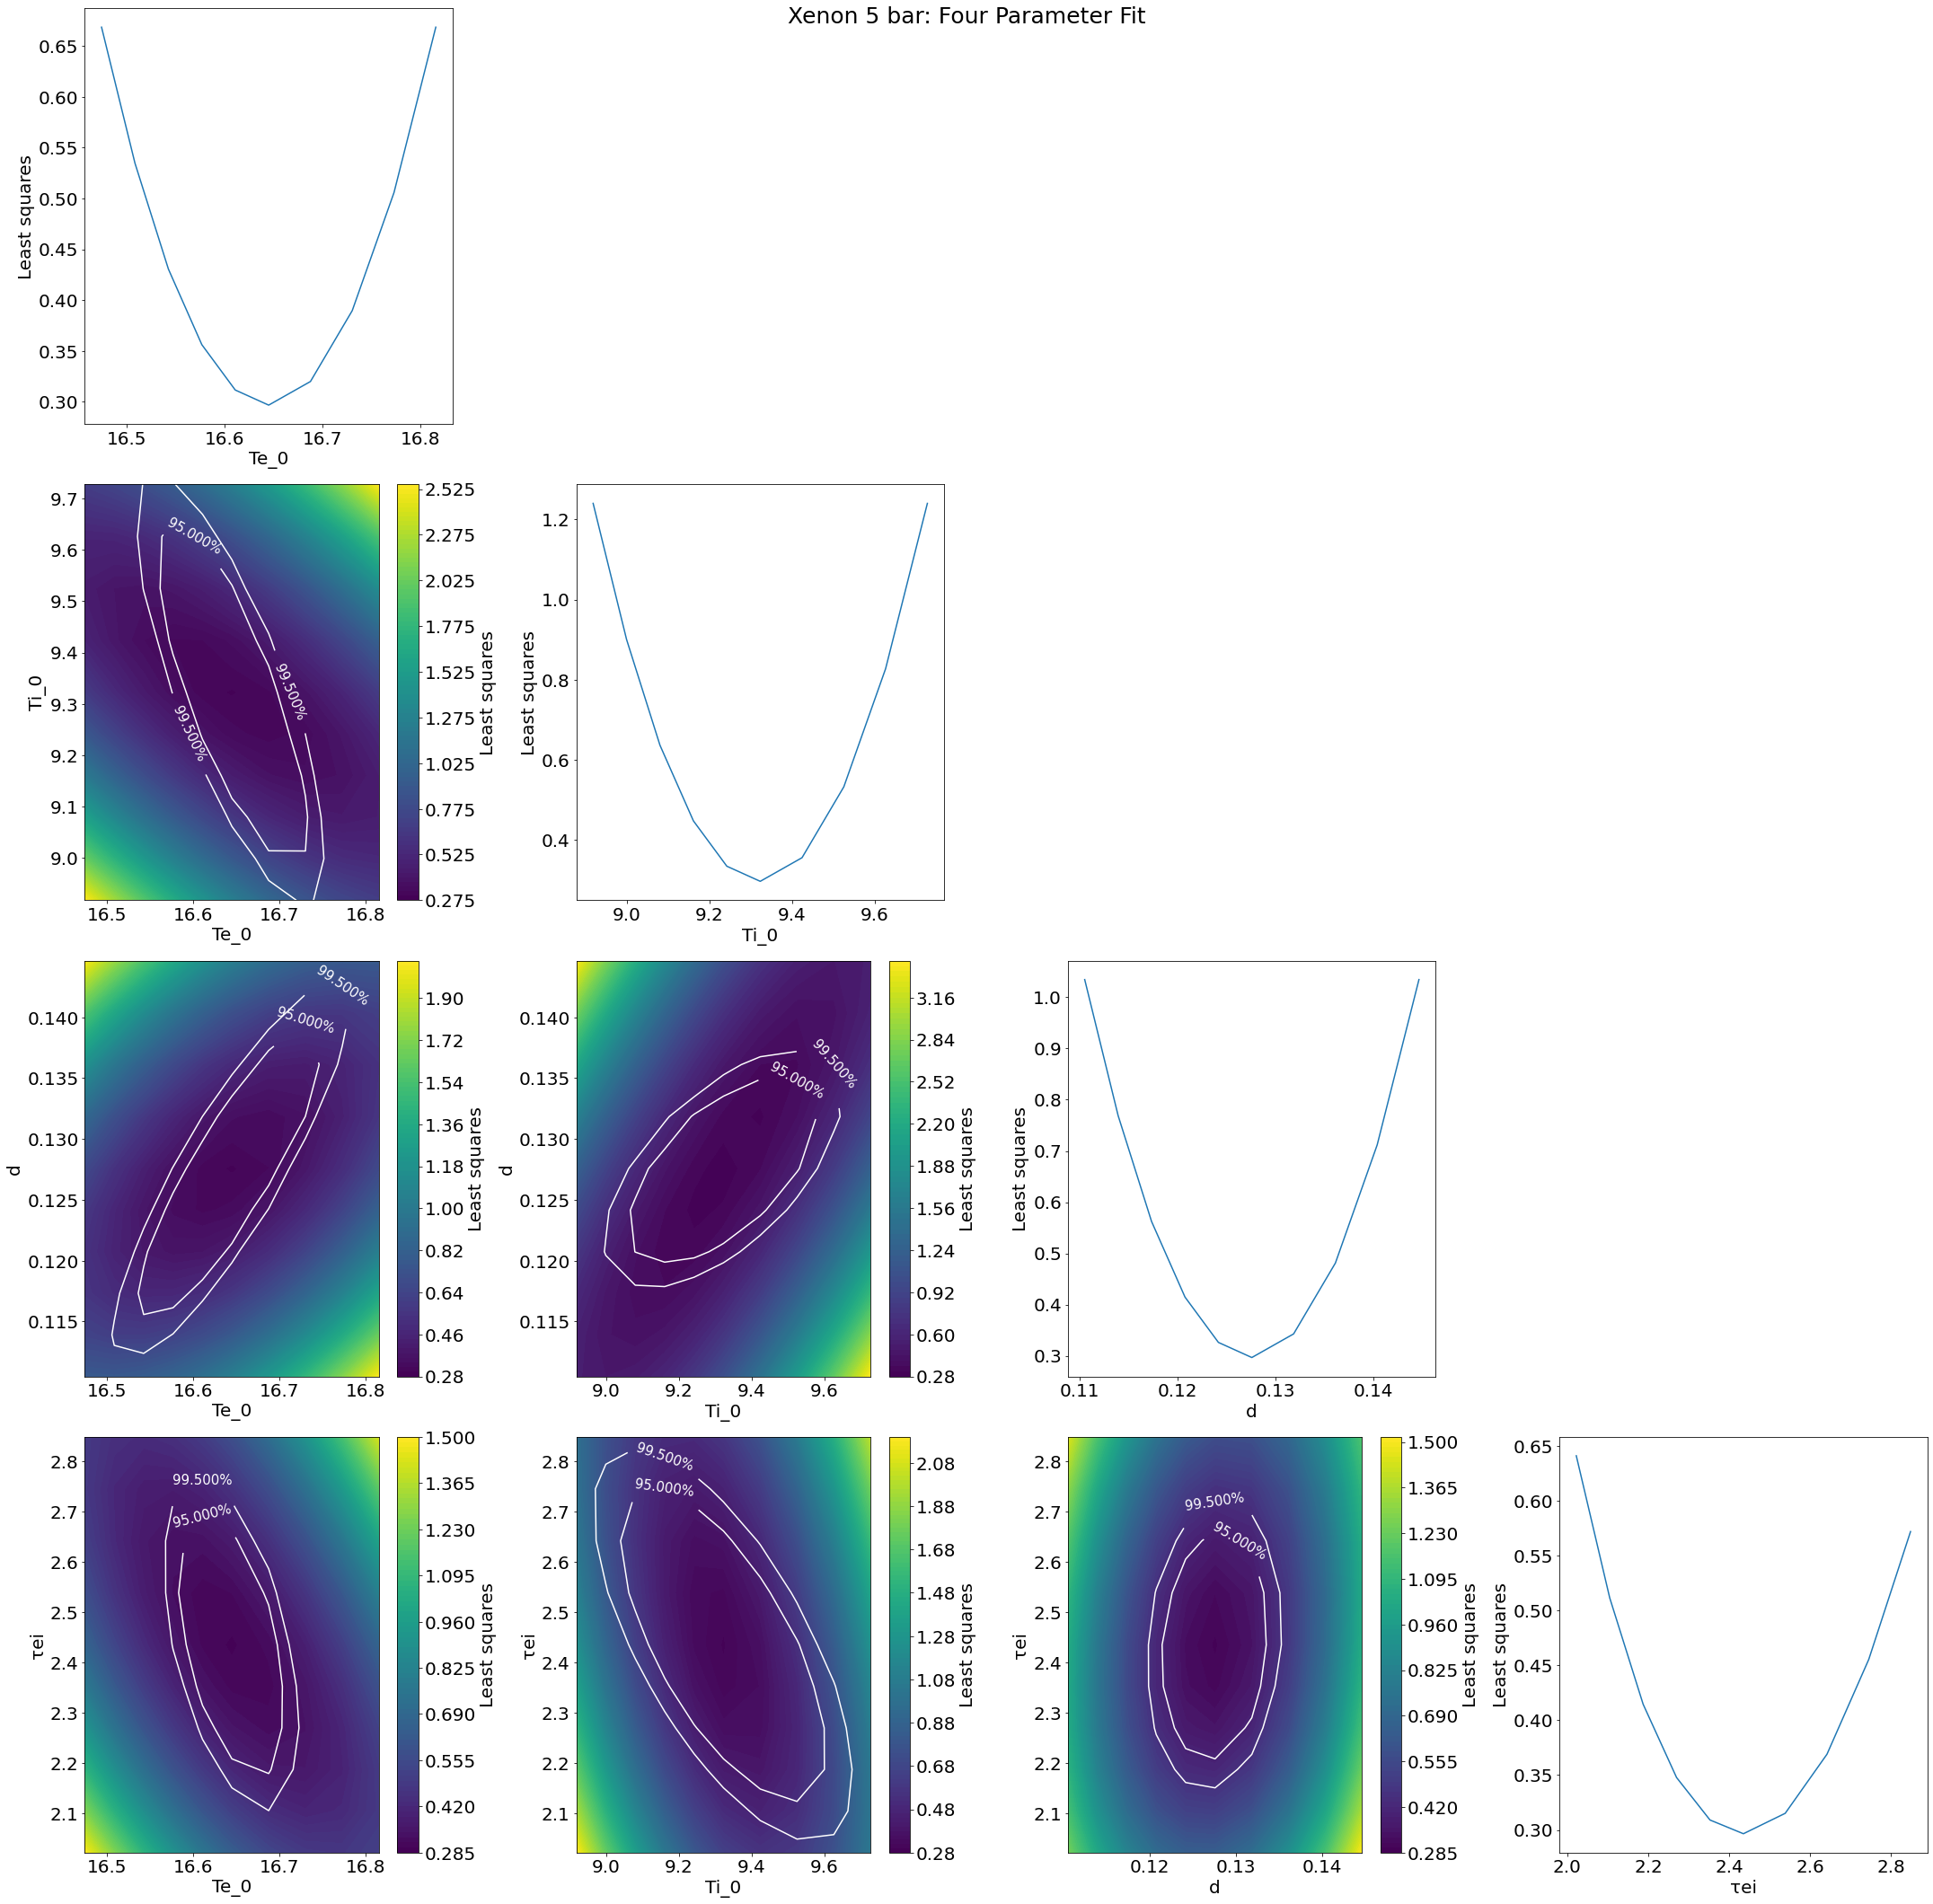

In [275]:
# Define the list of parameters
parameters = ['Te_0', 'Ti_0', 'd', 'τei']

# Create a grid of subplots
fig, axs = plt.subplots(len(parameters), len(parameters), figsize=(30, 30), facecolor='w')
fig.suptitle("Xenon 5 bar: Four Parameter Fit", fontsize=25)
# Loop over all pairs of parameters
for i in range(len(parameters)):
    for j in range(i+1):
        # Plot the 2D slice for this pair of parameters
        ax = axs[i, j]
        plt.sca(ax)  # Set the current Axes instance to ax

        if i == j:
            # On the diagonal, plot a line plot of the least squares values along the diagonal of the 2D slice
            param_range = param_ranges[parameters[i]]
            
            # Get the indices of the closest values to the best fit values for the other three dimensions
            other_axes = list(set(range(4)) - {i})
            other_indices = [np.abs(param_ranges[parameters[k]] - best_fit_values[parameters[k]]).argmin() for k in other_axes]

            # Get a 1D slice of the 4D grid
            slice_indices = [slice(None)] * 4
            slice_indices[other_axes[0]] = other_indices[0]
            slice_indices[other_axes[1]] = other_indices[1]
            slice_indices[other_axes[2]] = other_indices[2]
            lsq_slice = lsq_values[slice_indices]
            
            ax.plot(param_range, lsq_slice)
            ax.set_xlabel(parameters[i], fontsize=20)
            ax.set_ylabel('Least squares', fontsize=20)
            ax.tick_params(labelsize=20)
        else:
            # Off the diagonal, plot the 2D slice
            plot_2D_slice(ax, parameters[j], parameters[i])  # Note the reversed order to get a lower diagonal grid

        # Hide the Axes instances in the upper diagonal
        if i != j:
            axs[j, i].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.tight_layout()
plt.show()

In [8]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

class FitAnalysis:
    def __init__(self, Xe_data, T_fit_form):
        self.Xe_data = Xe_data
        self.T_fit_form = T_fit_form
        self.fit_vals, self.fit_cov = curve_fit(T_fit_form, Xe_data['t[ns]'], Xe_data['T[kK]'] , maxfev=int(1e4))
        self.σ = np.sqrt(np.diag(self.fit_cov))
        self.N = 10
        self.first_half = np.linspace(-1, 0, int(self.N/2), endpoint=False)
        self.second_half = np.linspace(0, 1, self.N-int(self.N/2))
        self.basic_array  = np.concatenate((self.first_half, self.second_half))
        self.param_ranges = [fit_val + 3*σ_val*self.basic_array for fit_val, σ_val in zip(self.fit_vals, self.σ)]
        self.lsq_values = np.empty([self.N]*len(self.fit_vals))
        self.parameter_normal   = multivariate_normal(self.fit_vals, self.fit_cov)
        self.probability_values = self.parameter_normal.pdf(np.stack(np.meshgrid(*self.param_ranges),axis=-1))
        self.probability_values *= 1/np.max(self.probability_values)
        self.parameters = ['param'+str(i) for i in range(len(self.fit_vals))]
        self.calculate_least_squares()

    def calculate_least_squares(self):
        index=0
        for indices in np.ndindex(*[self.N]*len(self.fit_vals)):
            print("{}".format(index/self.N**len(self.fit_vals)),end='\r')
            index += 1
            params = [param_range[i] for param_range, i in zip(self.param_ranges, indices)]
            T_pred = self.T_fit_form(self.Xe_data['t[ns]'], *params)
            residuals = self.Xe_data['T[kK]'] - T_pred
            lsq = np.sum(residuals**2)
            self.lsq_values[indices] = lsq

    def plot_2D_slice(self, ax, axis1, axis2):
        param1_range = self.param_ranges[axis1]
        param2_range = self.param_ranges[axis2]
        axes = ['param'+str(i) for i in range(len(self.fit_vals))]
        i = axes.index('param'+str(axis1))
        j = axes.index('param'+str(axis2))
        other_axes = list(set(range(len(self.fit_vals))) - {i, j})
        other_indices = [np.abs(param_range - self.fit_vals[k]).argmin() for k, param_range in enumerate(self.param_ranges) if k in other_axes]
        slice_indices = [slice(None)] * len(self.fit_vals)
        slice_indices[other_axes[0]] = other_indices[0]
        slice_indices[other_axes[1]] = other_indices[1]
        lsq_slice = self.lsq_values[tuple(slice_indices)]
        pdf_slice = self.probability_values[tuple(slice_indices)]
        lsq_min = np.min(self.lsq_values)
        lsq_std = np.std(self.lsq_values)
        sigma2_threshold = lsq_min + 2 * lsq_std
        cf = ax.contourf(param1_range, param2_range, lsq_slice.T, levels=100, cmap='viridis')
        cbar = plt.colorbar(cf)
        cbar.ax.set_ylabel('Least squares',fontsize=20)
        cbar.ax.tick_params(labelsize=20, which='both')
        chi_square_4df = [9.488,14.860]
        p_vals= [0.05,0.005]
        confidence_contours = plt.contour(param1_range, param2_range, -2*np.log(pdf_slice.T), colors='w', levels=chi_square_4df)
        def fmt(x):
            index = np.argmin(np.abs(x - chi_square_4df))
            return "{0:.3f}%".format(  (1-p_vals[index])*100)
        plt.clabel(confidence_contours, inline=1, fontsize=15, fmt= fmt)
        ax.set_xlabel('param'+str(axis1), fontsize=20)
        ax.set_ylabel('param'+str(axis2), fontsize=20)
        ax.tick_params(labelsize=20)

    def plot_all_slices(self):
        fig, axs = plt.subplots(len(self.parameters), len(self.parameters), figsize=(30, 30), facecolor='w')
        fig.suptitle("Xenon 5 bar: Four Parameter Fit", fontsize=25)
        for i in range(len(self.parameters)):
            for j in range(i+1):
                ax = axs[i, j]
                plt.sca(ax)
                if i == j:
                    param_range = self.param_ranges[i]
                    other_axes = list(set(range(len(self.fit_vals))) - {i})
                    other_indices = [np.abs(param_range - self.fit_vals[k]).argmin() for k, param_range in enumerate(self.param_ranges) if k in other_axes]
                    slice_indices = [slice(None)] * len(self.fit_vals)
                    slice_indices[other_axes[0]] = other_indices[0]
                    slice_indices[other_axes[1]] = other_indices[1]
                    slice_indices[other_axes[2]] = other_indices[2]
                    lsq_slice = self.lsq_values[tuple(slice_indices)]
                    ax.plot(param_range, lsq_slice)
                    ax.set_xlabel('param'+str(i), fontsize=20)
                    ax.set_ylabel('Least squares', fontsize=20)
                    ax.tick_params(labelsize=20)
                else:
                    self.plot_2D_slice(ax, j, i)
                if i != j:
                    axs[j, i].axis('off')
        plt.subplots_adjust(wspace=0.3, hspace=0.3)
        plt.tight_layout()
        plt.show()


# Model 1 (Four Parameters)
Assume $\tau \equiv \tau_{ei} = \tau_{ie}$

\begin{align}
\dot{T_e} &= - \tau (T_e - T_i) - d \\
\dot{T_i} &= + \tau (T_e - T_i) - d 
\end{align}


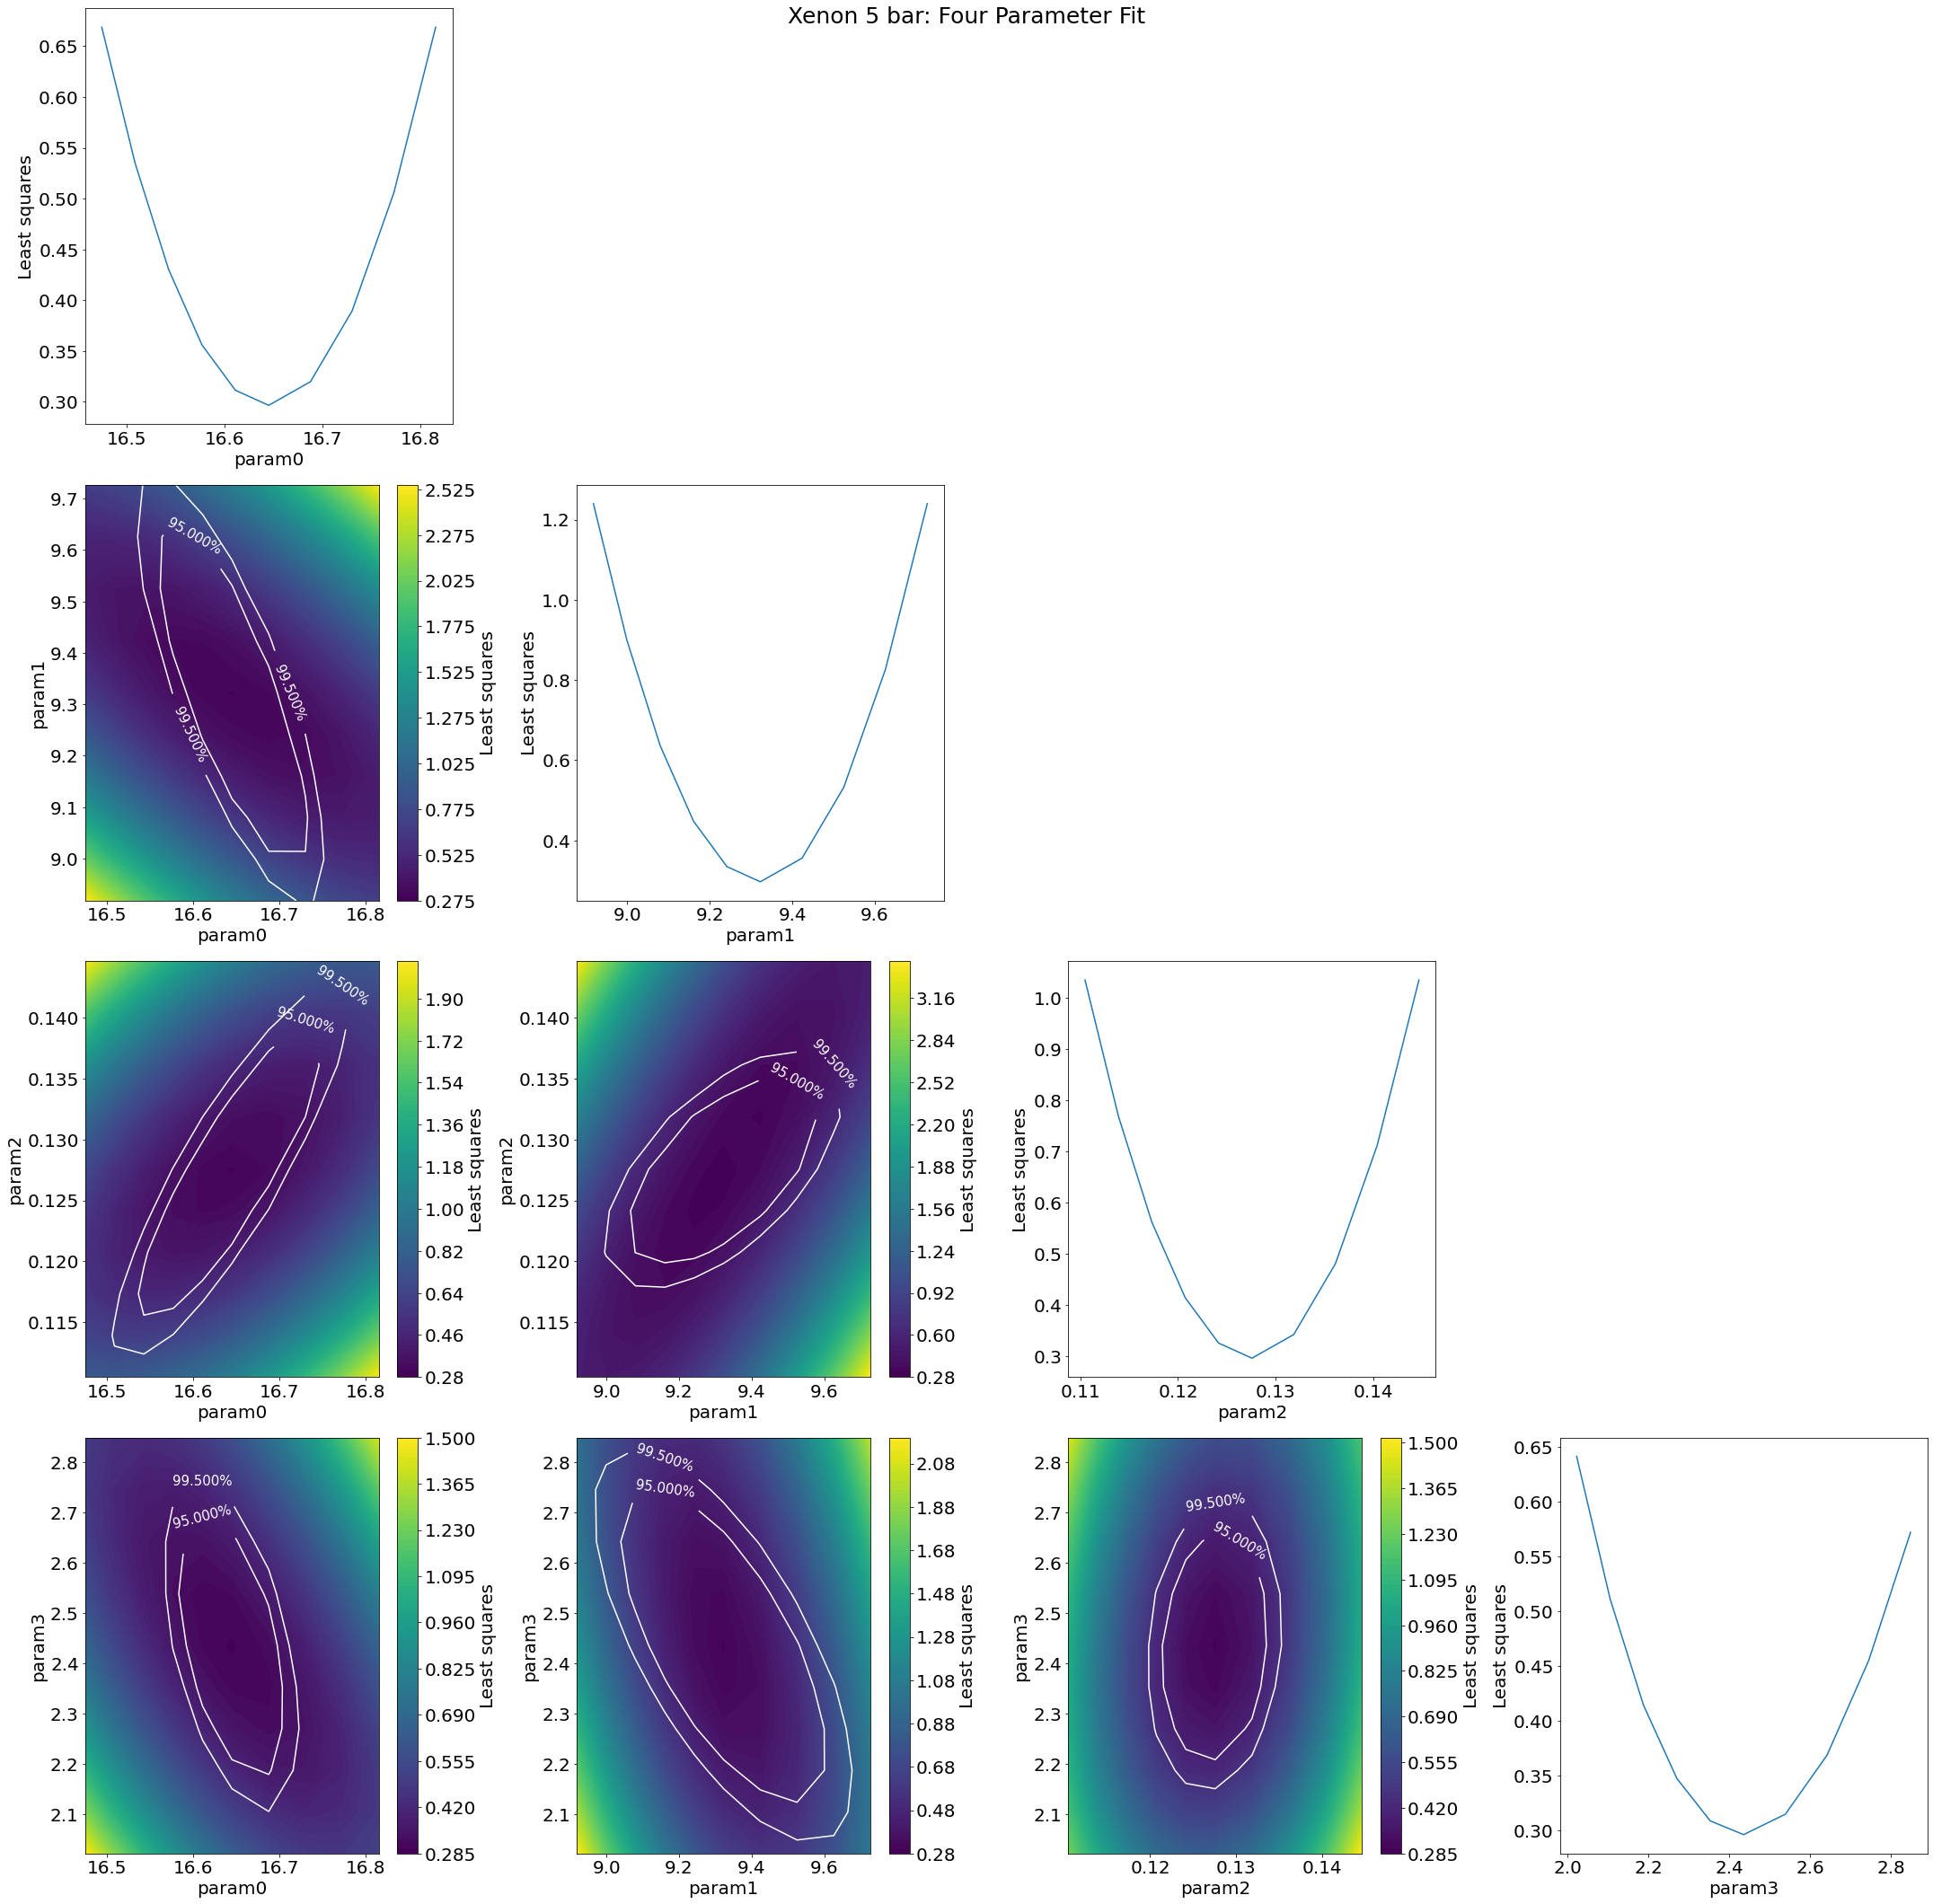

In [9]:
def T_model_1(t, Te_0, Ti_0, d, τei):
    ΔT0 = (Te_0-Ti_0)
    ΣT0 = (Te_0+Ti_0)
    return ΣT0/2 - d*t + ΔT0/2*np.exp(-2*t/τei)

analysis = FitAnalysis(Xe_data, T_model_1)
analysis.plot_all_slices()


# Model 2 (Six Parameters)
Include specific heats, and each species loses energy at the same rate

\begin{align}
c_e \dot{T_e} &= - G (T_e - T_i) - S \\
c_i \dot{T_i} &= + G (T_e - T_i) - S
\end{align}


In [10]:
def T_model_2(t, Te_0, Ti_0, G, S, ce, ci):
    ΔT0 = (Te_0-Ti_0)
    Σ_tilde_T0 = (ce*Te_0+ci*Ti_0)/(ce+ci)
    
    Σ_tilde_T = Σ_tilde_T0 - (2*S)/(ce+ci) * t
    ΔT = ΔT0 * np.exp(-t*G*(1/ce + 1/ci))
    
    Te = (ΔT + (ce+ci)*Σ_tilde_T/ci)/(1+ce/ci)
    return Te



In [11]:
analysis = FitAnalysis(Xe_data, T_model_2)
analysis.plot_all_slices()


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.